Test Accuracy: 79.16666666666666%
Test F-score: 0.7933535762483132
Predictions have been saved to test_data_with_predictions.csv


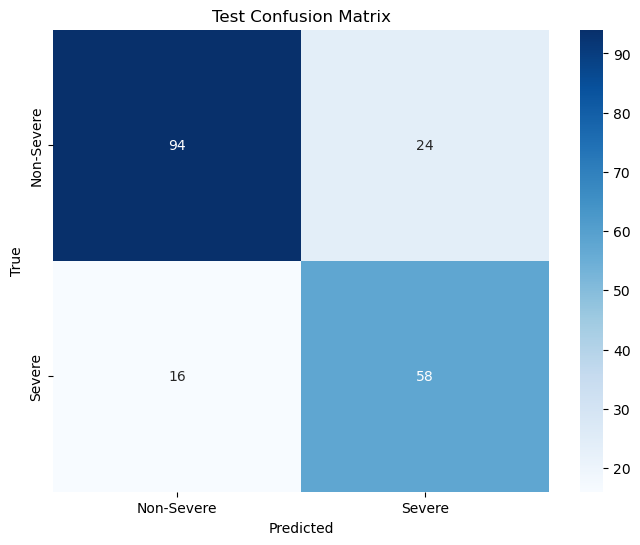

In [3]:
# TEST
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Load and preprocess the training data
data = pd.read_csv('data/dataTrainR85-15.csv') # Replace with your actual file path
class2idx = {'NS': 0, 'S': 1}
data = data[data["StructuralDamage"] != "-"]
data['StructuralDamage'].replace(class2idx, inplace=True)
X_train = data.iloc[:, 1:-1]
y_train = data.iloc[:, -1].astype('int')

class_names = ['Non-Severe', 'Severe']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define the model and other components
class CustomLoss(nn.Module):
    def __init__(self, fn_cost_weight):
        super(CustomLoss, self).__init__()
        self.fn_cost_weight = fn_cost_weight
        self.bce_loss = nn.BCELoss(reduction='none')  # Use 'none' to get the loss for each element

    def forward(self, output, target):
        # Compute binary cross-entropy loss for each element
        loss = self.bce_loss(output, target)
        
        # Convert target to float type
        target = target.float()

        # Compute false negative loss
        false_negatives = ((output < 0.5) & (target == 1)).float().sum()
        
        # Combine loss with false negative weight
        weighted_loss = loss + self.fn_cost_weight * false_negatives / target.size(0)
        
        return weighted_loss.mean()  # Mean loss for the batch
    

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(256, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.3)
        self.fc5 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.bn1(torch.relu(self.fc1(x))))
        x = self.dropout2(self.bn2(torch.relu(self.fc2(x))))
        x = self.dropout3(self.bn3(torch.relu(self.fc3(x))))
        x = self.dropout4(self.bn4(torch.relu(self.fc4(x))))
        x = self.sigmoid(self.fc5(x))
        return x

input_dim = X_train.shape[1]
model = MLP(input_dim)
criterion = CustomLoss(fn_cost_weight=3)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert y_train to a NumPy array
y_train = np.array(y_train)

# Initialize variables for collecting predictions and true labels
all_predictions = []
all_labels = []

# Initialize variables for overall validation accuracy and F-score
overall_accuracy = 0.0
overall_fscore = 0.0

num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)
fold = 1

# Variables to store the last fold's data and predictions
last_fold_train_data = None
last_fold_train_labels = None
last_fold_val_data = None
last_fold_val_labels = None
last_fold_predictions = None

# Variables to store the indices of the last fold's data
last_fold_train_indices = None
last_fold_val_indices = None

# Variables to store the last epoch's training predictions and true labels
last_epoch_train_predictions = None
last_epoch_train_labels = None


input_dim = X_train.shape[1]
model = MLP(input_dim)
criterion = CustomLoss(fn_cost_weight=3)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Test Performance Evaluation
# Load and preprocess the test data
test_data = pd.read_csv('data/dataTestR85-15.csv')  # Replace with your actual test file path
test_data = test_data[test_data["StructuralDamage"] != "-"]
test_data['StructuralDamage'].replace(class2idx, inplace=True)
X_test = test_data.iloc[:, 1:-1]
y_test = test_data.iloc[:, -1].astype('int')

# Scale the test data
X_test_scaled = scaler.transform(X_test)

# Convert the test data to PyTorch tensors
test_data_tensor = torch.tensor(X_test_scaled).float()
test_labels_tensor = torch.tensor(y_test.values).float()

# Load the saved model
model.load_state_dict(torch.load('model/best_model_with_smallest_fn.pth'))

# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(test_data_tensor)
    test_predictions = torch.round(test_outputs).squeeze()
    test_accuracy = (test_predictions == test_labels_tensor).sum().item() / len(test_labels_tensor) * 100
    test_confusion = confusion_matrix(y_test, test_predictions.numpy())
    test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, test_predictions.numpy(), average='weighted')

print(f"Test Accuracy: {test_accuracy}%")
print(f"Test F-score: {test_fscore}")

# Add predictions to the test data DataFrame
test_data['Prediction'] = test_predictions.numpy().astype(int)

# Save the test data with predictions to a CSV file
output_file_path = 'test_data_with_predictions.csv'
test_data.to_csv(output_file_path, index=False)

print(f"Predictions have been saved to {output_file_path}")

# Plotting the test confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()